In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import statsmodels.api as sm

from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss

In [2]:
# Load your power consumption data into a Pandas DataFrame
df = pd.read_csv('energy_weather_raw_data.csv', parse_dates=True)
df.date = pd.to_datetime(df.date, format='%Y-%m-%d %H:%M:%S')

In [3]:
# Load mapping between sky status categorical and numerical values
with open('category_mapping.pkl', 'rb') as f:
    category_mapping = pickle.load(f)

In [4]:
df = df.drop(columns=['description', 'temp', 'temp_t+1', 'feels_like_t+1'])

In [5]:
cat_cols = ['main']

for c in cat_cols:
    df[c] = pd.Categorical(df[c])
    df[c] = df[c].apply(lambda x: category_mapping[x])

## ARIMA model

In [6]:
ts = df['active_power'].dropna()

d = 0
d_thres = d

while True:
    print(f'Order differencing No. {d}:')

    adf_result = adfuller(ts)
    kpss_result = kpss(ts)

    print()
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:', adf_result[4])
    print()
    print('KPSS Statistic:', kpss_result[0])
    print('p-value:', kpss_result[1])
    print('Critical Values:', kpss_result[3])

    if adf_result[1] < 0.05 and kpss_result[1] >= 0.05:
        print('TS is stationary')
        break
    elif d >= 2:
        print('TS is NOT stationary')
    else:
        d += 1
        d_thres = d
        ts = df['active_power'].diff().dropna()
        print()
        print()

Order differencing No. 0:


/tmp/ipykernel_125679/3165571508.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(ts)



ADF Statistic: -31.997888622402257
p-value: 0.0
Critical Values: {'1%': -3.4303608058769823, '5%': -2.861544776072266, '10%': -2.5667725421284837}

KPSS Statistic: 14.691413820149359
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Order differencing No. 1:

ADF Statistic: -121.70133873277025
p-value: 0.0
Critical Values: {'1%': -3.4303608058948383, '5%': -2.8615447760801582, '10%': -2.5667725421326844}

KPSS Statistic: 0.0012746362175325599
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
TS is stationary


/tmp/ipykernel_125679/3165571508.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(ts)


In [7]:
ts = df['active_power'].diff().dropna()

d = 1
significant_lags = {}

while True:
    pac = pd.Series(sm.tsa.pacf(ts))

    significant_lags[pac[pac.idxmax()]] = pac.idxmax()

    if d >= 2:
        break
    else:
        d += 1
        ts = df['active_power'].diff().dropna()

max_key = max(significant_lags.keys())
p_thres = 1 + min([v for k, v in significant_lags.items() if k == max_key])

print('Most significant lag:', p_thres)

Most significant lag: 1


In [8]:
ts = df['active_power'].diff().dropna()
q_thres = pd.Series(np.abs(sm.tsa.acf(ts))).gt(0.05).sum()

## Model train

In [9]:
size = 517117 # Precisely 1 year of training data
train, test = df.iloc[:size], df.iloc[size:]

# Ensure the index is a datetime index
train = train.set_index('date')
train.index = pd.DatetimeIndex(train.index).to_period('min')

# Ensure the index is a datetime index
test = test.set_index('date')
test.index = pd.DatetimeIndex(test.index).to_period('min')

In [10]:
# Grid Search and Cross-Validation
# (Implement a loop to test different p, d, q combinations and evaluate performance)

# Select the best model based on AIC, BIC, and cross-validation results
p = range(0, p_thres+1)  # p ranges from 0 to 4 (not including 5)
d = d_thres              # d is fixed at 1
q = range(0, q_thres+1)  # q ranges from 0 to 1 (not including 2)

# Generate all combinations of p, d, q
pdq_combination = list(itertools.product(p, [d], q))

# Print the length of pdq_combination
print("Total combinations:", len(pdq_combination))

# Initialize lists to store results
r2 = []
mse = []
rmse = []
mae = []
mape = []
order1 = []

# Loop through each combination of p, d, q
for i, pdq in enumerate(pdq_combination):
    print('Trying order combination', i+1, 'out of', len(pdq_combination), ':', pdq)
    
    try:
        # Fit the ARIMA model on the training data
        model = ARIMA(endog=train.loc[:, train.columns[0]], exog=train.loc[:, train.columns[1:]], order=pdq,).fit()
    
        # Predict the values for the test set
        pred = model.predict(start=train.shape[0], end=(train.shape[0] + test.shape[0] - 1), exog=test.loc[:, test.columns[1:]])
    
        # Calculate error metrics
        score_r2 = metrics.r2_score(test.loc[:, test.columns[0]], pred)
        error_mse = metrics.mean_squared_error(test.loc[:, test.columns[0]], pred)
        error_rmse = metrics.root_mean_squared_error(test.loc[:, test.columns[0]], pred)
        error_mae = metrics.mean_absolute_error(test.loc[:, test.columns[0]], pred)
        error_mape = metrics.mean_absolute_percentage_error(test.loc[:, test.columns[0]], pred)
    
        # Append results to lists
        order1.append(pdq)
        r2.append(score_r2)
        mse.append(error_mse)
        rmse.append(error_rmse)
        mae.append(error_mae)
        mape.append(error_mape)
    except Exception as e:
        print(f"An error occurred for order {pdq}: {e}")
        continue

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Order': order1,
    'R^2': r2,
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
})

display(results)

# Find the row with the minimum RMSE
min_rmse_row = results.loc[results['RMSE'].idxmin()]
lowest_rmse_value = results['RMSE'].min()

print("Best parameters with lowest RMSE:")
print(min_rmse_row)
print("Lowest RMSE value:", lowest_rmse_value)

Total combinations: 8
Trying order combination 1 out of 8 : (0, 1, 0)
Trying order combination 2 out of 8 : (0, 1, 1)
Trying order combination 3 out of 8 : (0, 1, 2)
Trying order combination 4 out of 8 : (0, 1, 3)
Trying order combination 5 out of 8 : (1, 1, 0)
Trying order combination 6 out of 8 : (1, 1, 1)
Trying order combination 7 out of 8 : (1, 1, 2)


/home/bishop/miniconda3/envs/ve/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trying order combination 8 out of 8 : (1, 1, 3)


/home/bishop/miniconda3/envs/ve/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Order,R^2,MSE,RMSE,MAE,MAPE
0,"(0, 1, 0)",0.995435,142.779151,11.949023,8.899717,0.098228
1,"(0, 1, 1)",0.995572,138.470383,11.767344,8.698710,0.096363
2,"(0, 1, 2)",0.995565,138.713893,11.777686,8.713151,0.096484
3,"(0, 1, 3)",0.995587,138.026421,11.748465,8.679565,0.096178
4,"(1, 1, 0)",0.995486,141.161904,11.881158,8.827074,0.097529
5,"(1, 1, 1)",0.995727,133.636261,11.560115,8.460178,0.094272
6,"(1, 1, 2)",0.997021,93.156416,9.651757,6.348290,0.073753
7,"(1, 1, 3)",0.995839,130.145760,11.408144,8.287738,0.092638


Best parameters with lowest RMSE:
Order    (1, 1, 2)
R^2       0.997021
MSE      93.156416
RMSE      9.651757
MAE        6.34829
MAPE      0.073753
Name: 6, dtype: object
Lowest RMSE value: 9.65175712316294


R^2: 0.9957270606813861
MSE: 133.6362613870116
RMSE: 11.560115111321842
MAE: 8.460177648038512
MAPE: 0.09427193744113954


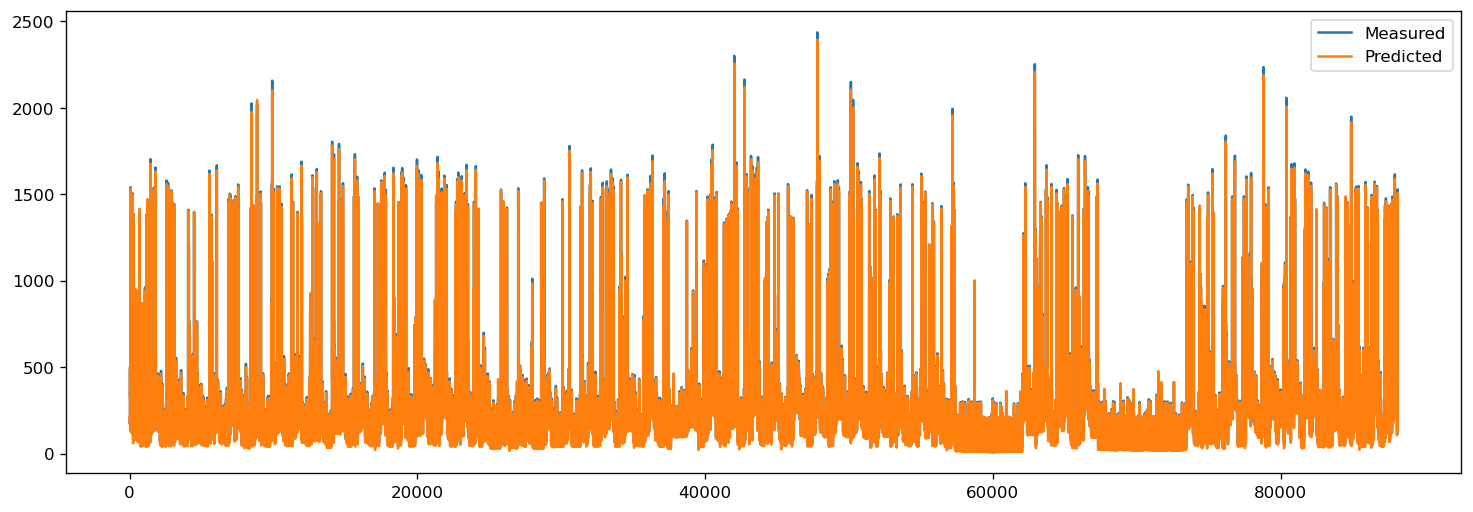

In [16]:
p = 1  # AR order
d = 1  # Differencing order
q = 1  # MA order

try:
    # Fit the ARIMA model on the training data
    model = ARIMA(endog=train.loc[:, train.columns[0]], exog=train.loc[:, train.columns[1:]], order=(p, d, q),).fit()

    # Predict the values for the test set
    pred = model.predict(start=train.shape[0], end=(train.shape[0] + test.shape[0] - 1), exog=test.loc[:, test.columns[1:]])

    # Calculate error metrics
    score_r2 = metrics.r2_score(test.loc[:, test.columns[0]], pred)
    error_mse = metrics.mean_squared_error(test.loc[:, test.columns[0]], pred)
    error_rmse = metrics.root_mean_squared_error(test.loc[:, test.columns[0]], pred)
    error_mae = metrics.mean_absolute_error(test.loc[:, test.columns[0]], pred)
    error_mape = metrics.mean_absolute_percentage_error(test.loc[:, test.columns[0]], pred)

    print('R^2:', score_r2)
    print('MSE:', error_mse)
    print('RMSE:', error_rmse)
    print('MAE:', error_mae)
    print('MAPE:', error_mape)

    plt.rcParams.update({'figure.figsize':(15,5), 'figure.dpi':120})
    plt.plot(list(range(test.shape[0])), test['active_power'], label='Measured')
    plt.plot(list(range(test.shape[0])), pred, label='Predicted')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"An error occurred for order {pdq}: {e}")

In [17]:
df_temp = df.set_index('date')
df_temp.index = pd.DatetimeIndex(df_temp.index).to_period('min')

p = 1  # AR order
d = 1  # Differencing order
q = 1  # MA order

# Create and fit the ARIMA model
try:
    # Fit the ARIMA model on the training data
    model_final = ARIMA(endog=df_temp.loc[:, df_temp.columns[0]], exog=df_temp.loc[:, df_temp.columns[1:]], order=(p, d, q),).fit()
except Exception as e:
    print(f"An error occurred for order {(p, d, q)}: {e}")

/home/bishop/miniconda3/envs/ve/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
df_temp = df.set_index('date')
df_temp.index = pd.DatetimeIndex(df_temp.index).to_period('min')

p = 0  # AR order
d = 1  # Differencing order
q = 1  # MA order

# Create and fit the ARIMA model
try:
    # Fit the ARIMA model on the training data
    model_final = ARIMA(endog=df_temp.loc[:, df_temp.columns[0]], exog=df_temp.loc[:, df_temp.columns[1:]], order=(p, d, q),).fit()
except Exception as e:
    print(f"An error occurred for order {(p, d, q)}: {e}")

In [7]:
# Store model to a pickle file
model_final.save('model_arima.pkl')